In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-12-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2020-12-31_2_2024-11-24 01_29_40.pt"

GRAPH_TITLE = "EIIE Trained 2009-2020, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3018, 8)


# Portfolio Optimization Algorithm

In [2]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73325447 0.49973674 0.79356218 0.56069532 0.53807884 0.51365253
 0.47050007 0.4535413  0.4616515  0.57103289 0.46439158 0.53378733
 0.61479425 0.58567169 0.80647558 0.50345004 0.72067673 0.72977091
 0.90836283 0.54361322 0.42626132 0.45990717 0.43075238 0.38731389
 0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.466

In [3]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_11112\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [4]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 860900.5
Final accumulative portfolio value: 0.8609005
Maximum DrawDown: -0.33211022504176313
Sharpe ratio: -0.22691498438638458
Total commission cost: 7982.003153646016


In [5]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2021-03-16
1      1.001067e+06 2021-03-17
2      9.784485e+05 2021-03-18
3      9.727899e+05 2021-03-19
4      9.872128e+05 2021-03-22
..              ...        ...
449    8.532841e+05 2022-12-23
450    8.497897e+05 2022-12-27
451    8.405122e+05 2022-12-28
452    8.559540e+05 2022-12-29
453    8.609005e+05 2022-12-30

[454 rows x 2 columns]


In [6]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-03-16 00:00:00
2022-12-30 00:00:00


In [7]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df

print(portfolio_norm_df)


environment_benchmarks = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

           date      open      high       low     close    volume   tic   day
0    2021-03-16  0.688277  0.695419  0.696293  0.686705  0.589604  AAPL  0.25
0    2021-03-16  1.000000  0.988032  0.991298  0.968208  0.713019    BA  0.25
0    2021-03-16  0.940616  0.959702  0.961729  0.949018  0.240929  INTC  0.25
0    2021-03-16  0.685625  0.686533  0.689480  0.688633  0.310655  MSFT  0.25
0    2021-03-16  0.894661  0.892785  0.895577  0.894170  0.233179     V  0.25
..          ...       ...       ...       ...       ...       ...   ...   ...
453  2022-12-30  0.712305  0.713057  0.729912  0.722675  0.099263    BA  1.00
453  2022-12-30  0.379765  0.386334  0.387213  0.410511  0.247661  INTC  1.00
453  2022-12-30  0.691225  0.686247  0.691584  0.705509  0.242605  MSFT  1.00
453  2022-12-30  0.825075  0.823366  0.828700  0.836831  0.108375     V  1.00
453  2022-12-30  0.883370  0.883187  0.885208  0.897379  0.086549   WMT  1.00

[2724 rows x 8 columns]


# Porfolio Baselines

In [8]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1096852.125
Final accumulative portfolio value: 1.096852125
Maximum DrawDown: -0.2573970342627847
Sharpe ratio: 0.34369678927620617
Total commission cost: 1.000240445137024e-06
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2021-03-16
1          9.916784e+05 2021-03-17
2          9.787301e+05 2021-03-18
3          9.917537e+05 2021-03-19
4          9.964962e+05 2021-03-22
..                  ...        ...
449        1.112169e+06 2022-12-23
450        1.112479e+06 2022-12-27
451        1.092984e+06 2022-12-28
452        1.099637e+06 2022-12-29
453        1.096852e+06 2022-12-30

[454 rows x 2 columns]


In [9]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 873787.625
Final accumulative portfolio value: 0.873787625
Maximum DrawDown: -0.290815603937541
Sharpe ratio: -0.21696465145408608
Total commission cost: 4122.479355827207
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2021-03-16
1         1.003868e+06 2021-03-17
2         9.797721e+05 2021-03-18
3         9.706844e+05 2021-03-19
4         9.826879e+05 2021-03-22
..                 ...        ...
449       8.728649e+05 2022-12-23
450       8.695564e+05 2022-12-27
451       8.571506e+05 2022-12-28
452       8.722964e+05 2022-12-29
453       8.737876e+05 2022-12-30

[454 rows x 2 columns]


In [10]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 880296.5625
Final accumulative portfolio value: 0.8802965625
Maximum DrawDown: -0.2759189704592835
Sharpe ratio: -0.20877557003518687
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2021-03-16
1         1.003868e+06 2021-03-17
2         9.797217e+05 2021-03-18
3         9.706304e+05 2021-03-19
4         9.825175e+05 2021-03-22
..                 ...        ...
449       8.813516e+05 2022-12-23
450       8.778469e+05 2022-12-27
451       8.647830e+05 2022-12-28
452       8.797722e+05 2022-12-29
453       8.802966e+05 2022-12-30

[454 rows x 2 columns]


In [11]:


# BAH on each individual stock

BAH_results = {
    "test": {},
}

# Weights are in alphabetical order

# AAPL
model_kwargs_AAPL={
    "target_weights": np.array([0,1,0,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_AAPL)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_AAPL = pd.DataFrame(BAH_results["test"]["value"], columns=['AAPL_net_worth'])
df_bah_date_AAPL = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_AAPL['Date'] = df_bah_date['Date']


# "BA"
model_kwargs_BA={
    "target_weights": np.array([0,0,1,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_BA)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_BA = pd.DataFrame(BAH_results["test"]["value"], columns=['BA_net_worth'])
df_bah_date_BA = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_BA['Date'] = df_bah_date['Date']

# "INTC"
model_kwargs_INTC={
    "target_weights": np.array([0,0,0,1,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_INTC)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_INTC = pd.DataFrame(BAH_results["test"]["value"], columns=['INTC_net_worth'])
df_bah_date_INTC = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_INTC['Date'] = df_bah_date['Date']

# "MSFT"
model_kwargs_MSFT={
    "target_weights": np.array([0,0,0,0,1,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_MSFT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_MSFT = pd.DataFrame(BAH_results["test"]["value"], columns=['MSFT_net_worth'])
df_bah_date_MSFT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_MSFT['Date'] = df_bah_date['Date']

# "V"

model_kwargs_V={
    "target_weights": np.array([0,0,0,0,0,1,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_V)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_V = pd.DataFrame(BAH_results["test"]["value"], columns=['V_net_worth'])
df_bah_date_V = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_V['Date'] = df_bah_date['Date']

# WMT
model_kwargs_WMT={
    "target_weights": np.array([0,0,0,0,0,0,1])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_WMT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_WMT = pd.DataFrame(BAH_results["test"]["value"], columns=['WMT_net_worth'])
df_bah_date_WMT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_WMT['Date'] = df_bah_date['Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1045581.125
Final accumulative portfolio value: 1.045581125
Maximum DrawDown: -0.30349082965788876
Sharpe ratio: 0.2329093524643334
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 746404.8125
Final accumulative portfolio value: 0.7464048125
Maximum DrawDown: -0.5604539794928671
Sharpe ratio: -0.19113696834776459
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 432563.75
Final accumulative portfolio value: 0.43256375
Maximum DrawDown: -0.616261305329699
Sharpe ratio: -1.2196281277454375
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1024504.3125
Final accumulative portfolio value: 1.0245043125
Maximum DrawDown: -0.3714850062368745
Sharpe ratio: 0.19265900180015508
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 935874.5
Final accumulative portfolio value: 0.9358745
Maximum DrawDown: -0.2860444100685773
Sharpe ratio: 0.006479118731735644
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1096852.125
Final accumulative portfolio value: 1.096852125
Maximum DrawDown: -0.2573970342627847
Sharpe ratio: 0.34369678927620617
Total commission cost: 0.0
hit end!


# Stock environment optimization algorithm

In [12]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (453, 8)
Annual return          0.006674
Cumulative returns     0.012029
Annual volatility      0.167793
Sharpe ratio           0.123543
Calmar ratio           0.030417
Stability              0.298355
Max drawdown          -0.219408
Omega ratio            1.021153
Sortino ratio          0.173110
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.996726
Daily value at risk   -0.021058
dtype: float64
df_dji:            date           dji
0   2021-03-16  1.000000e+06
1   2021-03-17  1.005770e+06
2   2021-03-18  1.001107e+06
3   2021-03-19  9.939688e+05
4   2021-03-22  9.971136e+05
..         ...           ...
449 2022-12-23  1.011515e+06
450 2022-12-27  1.012661e+06
451 2022-12-28  1.001516e+06
452 2022-12-29  1.012029e+06
453 2022-12-30           NaN

[454 rows x 2 columns]
df_dji:                       dji
date                    
2021-03-16  1.000000e+06
2021-03-17  1.005770e+06
2021-03-18  1.001107e+06
2021-03-19  9.939688e+05

# Compare all results

In [13]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt


df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')


# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge all stocks
df_bah_opt_AAPL['Date'] = pd.to_datetime(df_bah_opt_AAPL['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_AAPL, on='Date')

df_bah_opt_MSFT['Date'] = pd.to_datetime(df_bah_opt_MSFT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_MSFT, on='Date')

df_bah_opt_V['Date'] = pd.to_datetime(df_bah_opt_V['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_V, on='Date')

df_bah_opt_WMT['Date'] = pd.to_datetime(df_bah_opt_WMT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_WMT, on='Date')

df_bah_opt_BA['Date'] = pd.to_datetime(df_bah_opt_BA['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_BA, on='Date')

df_bah_opt_INTC['Date'] = pd.to_datetime(df_bah_opt_INTC['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_INTC, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-03-16  1.000000e+06
2021-03-17  1.005770e+06
2021-03-18  1.001107e+06
2021-03-19  9.939688e+05
2021-03-22  9.971136e+05
...                  ...
2022-12-23  1.011515e+06
2022-12-27  1.012661e+06
2022-12-28  1.001516e+06
2022-12-29  1.012029e+06
2022-12-30           NaN

[454 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2021-03-16        1.000000e+06       1.000000e+06   
1         1.003868e+06 2021-03-17        9.916784e+05       1.003868e+06   
2         9.797721e+05 2021-03-18        9.787301e+05       9.797217e+05   
3         9.706844e+05 2021-03-19        9.917537e+05       9.706304e+05   
4         9.826879e+05 2021-03-22        9.964962e+05       9.825175e+05   
..                 ...        ...                 ...                ...   
449       8.728649e+05 2022-12-23        1.112169e+06       8.813516e+05   
450       8.695564e+05 2022-12-27        1.

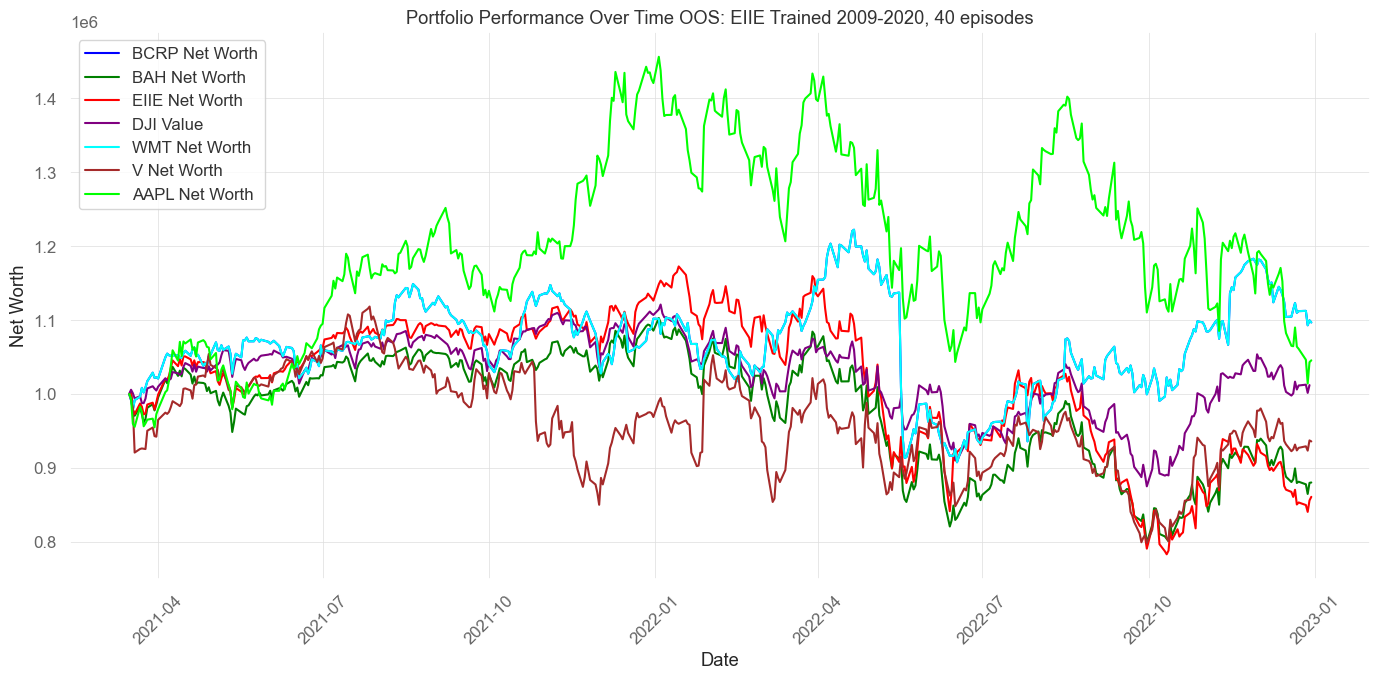

In [14]:
import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BCRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'WMT Net Worth': 'cyan',
    'V Net Worth': 'brown',
    'MSFT Net Worth': 'pink',
    'INTC Net Worth': 'gray',
    'BA Net Worth': 'black',
    'AAPL Net Worth': 'lime'
}

# Plot 1: OOS Portfolio Performance
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['bcrp_opt_net_worth'], label='BCRP Net Worth', color=color_map['BCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.plot(merged_df['Date'], merged_df['WMT_net_worth'], label='WMT Net Worth', color=color_map['WMT Net Worth'])
plt.plot(merged_df['Date'], merged_df['V_net_worth'], label='V Net Worth', color=color_map['V Net Worth'])
# plt.plot(merged_df['Date'], merged_df['MSFT_net_worth'], label='MSFT Net Worth', color=color_map['MSFT Net Worth'])
# plt.plot(merged_df['Date'], merged_df['INTC_net_worth'], label='INTC Net Worth', color=color_map['INTC Net Worth'])
# plt.plot(merged_df['Date'], merged_df['BA_net_worth'], label='BA Net Worth', color=color_map['BA Net Worth'])
plt.plot(merged_df['Date'], merged_df['AAPL_net_worth'], label='AAPL Net Worth', color=color_map['AAPL Net Worth'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
import pprint

final_returns = {
    'BCRP': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'WMT': merged_df['WMT_net_worth'].iloc[-1],
    'V': merged_df['V_net_worth'].iloc[-1],
    'MSFT': merged_df['MSFT_net_worth'].iloc[-1],
    'AAPL': merged_df['AAPL_net_worth'].iloc[-1],
    'BA': merged_df['BA_net_worth'].iloc[-1],
    'INTC': merged_df['INTC_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'AAPL': 1045581.125,
 'BA': 746404.8125,
 'BAH': 880296.5625,
 'BCRP': 1096852.125,
 'CRP': 873787.625,
 'EIIE': 860900.5,
 'INTC': 432563.75,
 'MSFT': 1024504.3125,
 'V': 935874.5,
 'WMT': 1096852.125}


In [16]:
import numpy as np
import pprint


# Calculate daily returns for each specified portfolio
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['WMT_opt_daily_return'] = merged_df['WMT_net_worth'].pct_change()
merged_df['V_opt_daily_return'] = merged_df['V_net_worth'].pct_change()
merged_df['MSFT_opt_daily_return'] = merged_df['MSFT_net_worth'].pct_change()
merged_df['AAPL_opt_daily_return'] = merged_df['AAPL_net_worth'].pct_change()
merged_df['BA_opt_daily_return'] = merged_df['BA_net_worth'].pct_change()
merged_df['INTC_opt_daily_return'] = merged_df['INTC_net_worth'].pct_change()

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate the Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'].dropna(), risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'].dropna(), risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'].dropna(), risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'].dropna(), risk_free_rate),
    'WMT': calculate_sharpe_ratio(merged_df['WMT_opt_daily_return'].dropna(), risk_free_rate),
    'V': calculate_sharpe_ratio(merged_df['V_opt_daily_return'].dropna(), risk_free_rate),
    'MSFT': calculate_sharpe_ratio(merged_df['MSFT_opt_daily_return'].dropna(), risk_free_rate),
    'AAPL': calculate_sharpe_ratio(merged_df['AAPL_opt_daily_return'].dropna(), risk_free_rate),
    'BA': calculate_sharpe_ratio(merged_df['BA_opt_daily_return'].dropna(), risk_free_rate),
    'INTC': calculate_sharpe_ratio(merged_df['INTC_opt_daily_return'].dropna(), risk_free_rate),

}


pprint.pprint(sharpe_ratios)

{'AAPL': 0.167530123792847,
 'BA': -0.2401056195732975,
 'BAH': -0.29917614045580204,
 'BCRP': 0.2539733621228332,
 'CRP': -0.30529115978072285,
 'EIIE': -0.310422639699587,
 'INTC': -1.2806343404200788,
 'MSFT': 0.12507703191915295,
 'V': -0.06523504969296752,
 'WMT': 0.2539733621228332}


In [17]:
import numpy as np
import pandas as pd


# Define a function to calculate the max drawdown
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

# Calculate max drawdowns for each portfolio
max_drawdowns = {
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'WMT': max_drawdown(merged_df['WMT_net_worth']),
    'V': max_drawdown(merged_df['V_net_worth']),
    'MSFT': max_drawdown(merged_df['MSFT_net_worth']),
    'AAPL': max_drawdown(merged_df['AAPL_net_worth']),
    'BA': max_drawdown(merged_df['BA_net_worth']),
    'INTC': max_drawdown(merged_df['INTC_net_worth']),
}

pprint.pprint(max_drawdowns)


{'AAPL': -0.30349082965788876,
 'BA': -0.5604539794928671,
 'BAH': -0.2759189704592835,
 'BCRP': -0.2573970342627847,
 'CRP': -0.290815603937541,
 'EIIE': -0.33211022504176313,
 'INTC': -0.616261305329699,
 'MSFT': -0.3714850062368745,
 'V': -0.2860444100685773,
 'WMT': -0.2573970342627847}


In [18]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'INTC': calculate_up_days_ratio(merged_df['INTC_opt_daily_return']),
    'WMT': calculate_up_days_ratio(merged_df['WMT_opt_daily_return']),
    'V': calculate_up_days_ratio(merged_df['V_opt_daily_return']),
    'MSFT': calculate_up_days_ratio(merged_df['MSFT_opt_daily_return']),
    'AAPL': calculate_up_days_ratio(merged_df['AAPL_opt_daily_return']),
    'BA': calculate_up_days_ratio(merged_df['BA_opt_daily_return']),
}

pprint.pprint(up_days_ratios)

{'AAPL': 0.5055187637969095,
 'BA': 0.4746136865342163,
 'BAH': 0.49448123620309054,
 'BCRP': 0.5364238410596026,
 'CRP': 0.4900662251655629,
 'EIIE': 0.48123620309050774,
 'INTC': 0.45474613686534215,
 'MSFT': 0.4900662251655629,
 'V': 0.5033112582781457,
 'WMT': 0.5364238410596026}


In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq     df         F    PR(>F)
Portfolio  2.404060e-07    1.0  0.001133  0.973151
Residual   1.917528e-01  904.0       NaN       NaN


In [20]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.003868
2     -0.024053
3     -0.009279
4      0.012247
5     -0.010159
         ...   
449    0.001929
450   -0.003977
451   -0.014882
452    0.017333
453    0.000596
Name: BAH_opt_daily_return, Length: 453, dtype: float64
t-statistic: -0.03366557384846057
p-value: 0.9731512631081325
